In [1]:
# Train the CNN Emotion Regression Model with MIDI data#
# Last editted by Pu Zeng, 19/10/2023 #

In [3]:
import os
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
# import mido
import string
import numpy as np
# from utilis import get_pianoroll_data
import pickle
import os
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
# import mido
import string
import numpy as np
# from utilis import get_pianoroll_data
import pickle
from sklearn import preprocessing
import torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

from torch.utils.data import TensorDataset


RuntimeError: Detected that PyTorch and torchvision were compiled with different CUDA versions. PyTorch has CUDA Version=11.8 and torchvision has CUDA Version=11.7. Please reinstall the torchvision that matches your PyTorch install.

In [64]:
file=open("lakh_emotion.bin","rb")
music_data = pickle.load(file) #保存list到文件
file.close()

In [65]:
# Show the original labels generated by Flan-T5
np.unique([x[1] for x in music_data])

array(["a-livin'", 'achey', 'ah', 'ah!',
       "ahah,ahva,vava.we'll take a dream on a sunday,we'll take a life,take a holiday.take a lie,take a dreamer,dream",
       'ahh', 'ahum', 'amazing', 'anger', 'angry', 'arousal', 'awe',
       'bad', 'big', 'bitter', 'bittersweet', 'calm', 'cold', 'confused',
       'darkness', 'ecstasy', 'ecstatic', 'eloquent',
       'emertimenessed by midnight cinglight tying live phonebovelingney, ry where thing no more foremertimenessed by summertimemertimenesss-summertimemertime',
       'emotion', 'emotional', 'emozione', 'enlightened', 'esattino',
       'ethereal', 'euphoria',
       'evtiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiii', 'excited',
       'fear', 'fearful', 'foolish', 'free as a bird', 'frightful',
       "frozen inside without your touch without your love, darling only you are the life among the dead of this i, i can't believe i couldn't see kept in the dark, but you were there in front of me]",
       'good', 'grateful', 'happy', 'h

In [97]:
# Selected the most common one word labels
from tqdm import tqdm
X = []
y = []
chosen_label = ['sadness', 'happy', 'love', 'joy', 'negative', 'positive', 'anger',
       'awe', 'emotional', 'hopeful', 'angry', 'excited', 'fear', 'hurt',
       'fearful']
# for i in tqdm(range(1,10)):
file=open("lakh_emotion.bin","rb")
music_data = pickle.load(file) #保存list到文件
file.close()
for m in music_data:
    if m[1] in chosen_label:
        X.append(m[0])
        if m[1] == 'anger':
            m[1] = 'angry'
        if m[1] == 'fearful':
            m[1] = 'fear'
        if m[1] == 'joy':
            m[1] = 'happy'
        y.append(m[1])
X = np.array(X)

In [98]:
# Get the number of classes
num_labels = len(np.unique(y))

In [101]:
# Transform labels into one-hot variable

from sklearn import preprocessing
import torch

le = preprocessing.LabelEncoder()
y = le.fit_transform(y)

label_dict = {}
for cl in le.classes_:
    label_dict.update({cl:le.transform([cl])[0]})

In [4]:
#Define CNN model
class CNNModel(nn.Module):
    def __init__(self, hiddenSize, outChannels, dropoutRate, activate):
        super().__init__()
        self.outChannels = outChannels
        self.activate = nn.Sigmoid() if activate == "Sigmoid" else nn.ReLU()
        self.conv1 = nn.Conv2d(1, 24, (10,1))
        self.pool = nn.MaxPool2d((2, 1))
        self.conv2 = nn.Conv2d(24, 48, (10,1))
        self.conv3 = nn.Conv2d(48, 96, (10,1))
        self.conv4 = nn.Conv2d(96, 192, (10,1))
        self.conv5 = nn.Conv2d(192, 384, (5,2))
        self.conv6 = nn.Conv2d(384, 192, (5,2))
        self.dense1 = nn.Linear(48384, hiddenSize)
        self.dropout = nn.Dropout(dropoutRate)
        self.dense2 = nn.Linear(hiddenSize, num_labels)

    def forward(self, x):
        x = self.pool(self.activate(self.conv1(x)))
        x = self.pool(self.activate(self.conv2(x)))
        # print(x.shape)
        x = self.dropout(self.pool(self.activate(self.conv3(x))))
        x = self.pool(self.activate(self.conv4(x)))
        x = self.pool(self.activate(self.conv5(x)))
        x = self.pool(self.activate(self.conv6(x)))
        # print(x.shape)
        x = x.view(-1, 48384)
        x = self.dropout(self.activate(self.dense1(x)))
        return self.dense2(x)

# Number of neurons in the first fully-connected layer
hiddenSize = 4096
# Number of feature filters in second convolutional layer
numFilters = 25
# Dropout rate
dropoutRate = 0.2
# Activation function
activation = "ReLU"
# Learning rate
learningRate = 0.005
# Momentum for SGD optimizer
momentum = 0.9
# Number of training epochs
numEpochs = 20

In [102]:
#Define Trian and Validation function
from tqdm import tqdm
def train_epoch(cnn,device,dataloader,loss_fn,optimizer):
    cnn.train()
    cnnRunningLoss = 0
    total = 0
    R2 = 0
    cnnCorrect=0
    total1=0
    for i, (inputs, labels) in enumerate(dataloader, 0):
        optimizer.zero_grad()
        inputs = inputs.to('cuda').reshape(-1,1,512,128)
        
        labels = labels.to('cuda')
        # Forward propagation
        cnnOutputs = cnn(inputs)
        # print(cnnOutputs.shape)
        l2_lambda = 0.001
        l2_reg = torch.tensor(0.).to('cuda')
        for param in cnn.parameters():
            l2_reg += torch.norm(param)
        # Backpropagation
        cnnLoss = criterion(cnnOutputs, labels)+l2_reg*l2_lambda
        cnnLoss.backward()
        # Gradient update
        optimizer.step()
        total += 1
        total1+=labels.size(0)
        cnnRunningLoss += cnnLoss.item()
        _, cnnPredicted = torch.max(cnnOutputs.data, 1)
        cnnCorrect += (cnnPredicted == labels).sum().item()
    return cnnRunningLoss/total, cnnCorrect/total1

def valid_epoch(cnn,device,dataloader,loss_fn):
    cnn.eval()
    totalLoss = 0
    total = 0
    total1 = 0
    R2 = 0
    cnnLoss = 0
    cnnCorrect=0
    for inputs, labels in dataloader:
        inputs = inputs.to('cuda').reshape(-1,1,512,128)
        labels = labels.to('cuda')
        cnnOutputs = cnn(inputs)
        cnnLoss = loss_fn(cnnOutputs, labels)
        _, cnnPredicted = torch.max(cnnOutputs.data, 1)
        total += labels.size(0)
        total1 +=1
        totalLoss += cnnLoss.item()
        cnnCorrect += (cnnPredicted == labels).sum().item()
    accuracy = cnnCorrect / total * 100
    cnn.train()
    return totalLoss/total1, accuracy

In [103]:
# Train the model
import sklearn
from sklearn.model_selection import StratifiedKFold
X_train_v, X_test, y_train_v, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # First Split the dataset and use the training set for 5-fold validation

X_train_v = torch.as_tensor(X_train_v, dtype=torch.float) # an alternative to torch.from_numpy
y_train_v = torch.as_tensor(y_train_v, dtype=torch.float)
X_test = torch.as_tensor(X_test, dtype=torch.float)
y_test = torch.as_tensor(y_test, dtype=torch.float)
splits=StratifiedKFold(n_splits=5,shuffle=True,random_state=99)
train_dataset = TensorDataset(X_train_v, y_train_v)
test_dataset = TensorDataset(X_test, y_test)
batch_size=128
models = []
history = {'fold':[], 'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc':[]}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
for fold, (train_idx,val_idx) in enumerate(splits.split(X_train_v,y_train_v)):
    print('Fold {}'.format(fold + 1))
    t = pd.DataFrame(y_train_v[train_idx], columns = ['class']).reset_index()
    idx = []
    # Resample to avoid unbalanced dataset
    y_train = []
    for i in range(0,num_labels):
      idx += list(t[t['class']==i].sample(100,replace=True)['index'])
      y_train += [i]*100
    X_train = X_train_v[train_idx][idx]

    t = pd.DataFrame(y_train_v[val_idx], columns = ['class']).reset_index()
    idx = []
    y_val = []
    for i in range(0,num_labels):
      # print(i)
      if i in t['class'].values:
          idx += list(t[t['class']==i].sample(20,replace=True)['index'])
          y_val += [i]*20
    X_val =  X_train_v[val_idx][idx]

    X_train = torch.as_tensor(X_train, dtype=torch.float) # an alternative to torch.from_numpy
    y_train = torch.as_tensor(y_train, dtype=torch.float).type(torch.LongTensor)
    X_val = torch.as_tensor(X_val, dtype=torch.float)
    y_val = torch.as_tensor(y_val, dtype=torch.float).type(torch.LongTensor)

    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_val, y_val)

    from torch.utils.data import Dataset, DataLoader
    train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)
    
    model = CNNModel(hiddenSize, numFilters, dropoutRate, activation).to('cuda')
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(list(model.parameters()), lr=learningRate, momentum=momentum)
    # optimizer = torch.optim.Adam(list(model.parameters()), lr=learningRate)
    best_test = -np.inf
    best_model = None
    
    for epoch in range(numEpochs):
        train_loss, train_R2=train_epoch(model,device,train_dataloader,criterion,optimizer)
        test_loss, test_R2=valid_epoch(model,device,test_dataloader,criterion)
        history['fold'].append(fold)
        history['train_loss'].append(train_loss)
        history['test_loss'].append(test_loss)
        history['train_acc'].append(train_R2)
        history['test_acc'].append(test_R2)   
        if test_R2>best_test:
            test_test = test_R2
            best_model = model
        print('Train Loss: {}, Train_acc: {}, Test Loss: {}, Test acc: {}'.format(train_loss, train_R2, test_loss, test_R2))
    models.append([best_model])

Fold 1
Train Loss: 2.544879150390625, Train_acc: 0.11, Test Loss: 2.511772036552429, Test acc: 10.833333333333334
Train Loss: 2.3728294134140016, Train_acc: 0.18, Test Loss: 2.6150710582733154, Test acc: 15.833333333333332
Train Loss: 2.0665850758552553, Train_acc: 0.32083333333333336, Test Loss: 2.725834608078003, Test acc: 24.166666666666668
Train Loss: 1.8275741457939148, Train_acc: 0.44416666666666665, Test Loss: 2.853182077407837, Test acc: 20.416666666666668
Train Loss: 1.5240383625030518, Train_acc: 0.5291666666666667, Test Loss: 3.3484232425689697, Test acc: 33.33333333333333
Train Loss: 1.381859004497528, Train_acc: 0.59, Test Loss: 3.337221145629883, Test acc: 36.25
Train Loss: 1.2434839844703673, Train_acc: 0.6158333333333333, Test Loss: 4.394578695297241, Test acc: 36.666666666666664
Train Loss: 1.1272317469120026, Train_acc: 0.6358333333333334, Test Loss: 5.6733386516571045, Test acc: 32.916666666666664
Train Loss: 1.1377168953418733, Train_acc: 0.65, Test Loss: 4.99101662

In [104]:
# Caculate the average accuray
t = pd.DataFrame(y_test, columns = ['class']).reset_index()
idx = []
y_test = []
for i in range(0,num_labels):
    if i in t['class'].values:
        idx += list(t[t['class']==i].sample(20,replace=True)['index'])
        y_test += [i]*20
X_test =  X_test[idx]
X_test = torch.as_tensor(X_test, dtype=torch.float)
y_test = torch.as_tensor(y_test, dtype=torch.float).type(torch.LongTensor)
test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)
acc=[]
for best_model in models:
    acc.append(valid_epoch(best_model[0],device,test_dataloader,criterion)[1])

In [105]:
np.mean(acc)

47.583333333333336

In [111]:
outputs = []    
for model in models:
  model[0].eval()
  model_output = []
  label_= []
  model[0].to('cpu')
  for inputs, labels in test_dataloader:
      inputs = inputs.to('cpu').reshape(-1,1,512,128)
      labels = labels.to('cpu')
      cnnOutputs = model[0](inputs)
      model_output.append(cnnOutputs)
      label_.append(labels)
  outputs.append(torch.vstack(model_output))
cnnresult = torch.vstack(outputs).reshape(-1,shape[0],shape[1]).mean(axis=0)
labels = np.hstack(label_)
_, cnnPredicted = torch.max(cnnresult.data, 1)
cnnCorrect = (cnnPredicted.detach().numpy() == labels).sum().item()
cnnCorrect/len(labels)*100

51.66666666666667

<Axes: >

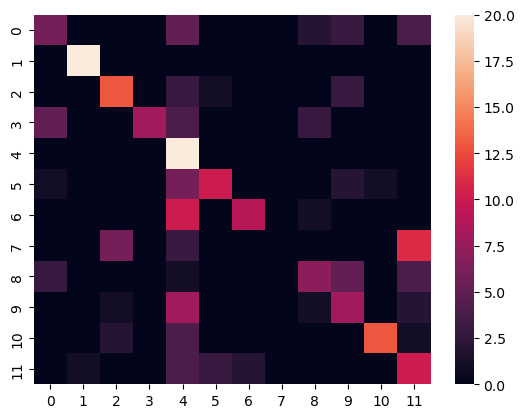

In [112]:
# Draw the confusion matrix
from sklearn.metrics import confusion_matrix
confu_m = confusion_matrix(labels, cnnPredicted)
import seaborn as sns
sns.heatmap(confu_m,square=False)

In [113]:
label_dict = {}
for cl in le.classes_:
    label_dict.update({cl:le.transform([cl])[0]})
label_dict

{'angry': 0,
 'awe': 1,
 'emotional': 2,
 'excited': 3,
 'fear': 4,
 'happy': 5,
 'hopeful': 6,
 'hurt': 7,
 'love': 8,
 'negative': 9,
 'positive': 10,
 'sadness': 11}

In [114]:
from sklearn.metrics import precision_recall_fscore_support
scores = pd.DataFrame(precision_recall_fscore_support(cnnPredicted, labels, labels = list(range(12))),index=['precision','recall','f1','support'], columns = list(label_dict)[:12])
scores

/mnt/storage/CIIP_group/Postdoc/Aiqi_Sun/anaconda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,angry,awe,emotional,excited,fear,happy,hopeful,hurt,love,negative,positive,sadness
precision,0.300000,1.000000,0.650000,0.400000,1.000000,0.500000,0.450000,0.0,0.350000,0.400000,0.650000,0.500000
recall,0.400000,0.952381,0.590909,1.000000,0.294118,0.714286,0.818182,0.0,0.500000,0.380952,0.928571,0.312500
f1,0.342857,0.975610,0.619048,0.571429,0.454545,0.588235,0.580645,0.0,0.411765,0.390244,0.764706,0.384615
support,15.000000,21.000000,22.000000,8.000000,68.000000,14.000000,11.000000,0.0,14.000000,21.000000,14.000000,32.000000
